## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part 1 - Probability & Cleaning the Data](#probability)
- [Part 2 - A/B Test](#ab_test)
- [Part 3 - Regression](#regression)


<a id='intro'></a>
## Introduction

For this project, I am working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert", meaning the number of users who decide to pay for the company's product. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer before making their decision.


<a id='probability'></a>
## Part 1 - Probability & Cleaning the Data

### 1. Clean and Investigate the Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# I have set the seed so others who run the analysis can compare their results to mine
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# check for duplicate rows
df.duplicated().sum()

0

In [4]:
# number of rows
df.shape[0]

294478

In [5]:
# number of unique users in the dataset
df['user_id'].nunique()

290584

In [6]:
# proportion of users converted
df['converted'].mean()

0.11965919355605512

In [7]:
# number of times new_page and treatment don't line up
treat_and_old = df.query('group == "treatment" and landing_page == "old_page"')
contr_and_new = df.query('group == "control" and landing_page == "new_page"')

temp_df = pd.concat([treat_and_old, contr_and_new], ignore_index=True)
temp_df.shape[0]

3893

In [8]:
# do any of these rows have missing values
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 5 columns):
user_id         3893 non-null int64
timestamp       3893 non-null object
group           3893 non-null object
landing_page    3893 non-null object
converted       3893 non-null int64
dtypes: int64(2), object(3)
memory usage: 152.2+ KB


In [9]:
# update df without the mismatched rows
treat_and_new = df.query('group == "treatment" and landing_page == "new_page"')
contr_and_old = df.query('group == "control" and landing_page == "old_page"')

df = pd.concat([treat_and_new, contr_and_old], ignore_index=True)

In [10]:
# double Check all of the correct rows were removed - this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# check how many unique user ids there are in df2
df['user_id'].nunique()

290584

In [12]:
# this seems to be one less than the total shape, double check the total shape
df.shape[0]

290585

In [13]:
# find the rows for the duplicated user id
df[df.duplicated(['user_id'], keep=False)]

# the duplicated user_id is a single user who visited the page two separate times and failed to convert both times
# these may be the same user, however they are two valid interactions and should both be included

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### 2. Compute the necessary probabilities

In [14]:
# probability of an individual converting regardless of page
df['converted'].mean()

0.11959667567149027

In [15]:
# probability of conversion given the individual is in the control group
df.query('group == "control"')['converted'].mean()

0.1203863045004612

In [16]:
# probability of conversion given the individual is in the treatment group
df.query('group == "treatment"')['converted'].mean()

0.11880724790277405

In [17]:
# probability an individual received the new page
df.query('landing_page == "new_page"').shape[0]/df.shape[0]

0.5000636646764286

### 3. Conclusion

The above probabilities do NOT provide sufficient evidence to prove that the new page leads to more conversions. The probabilities of 0.1204 and 0.1188 for the control and treatments groups, respectively, are too similar to prove that either group has an increased or decreased conversion rate.

<a id='ab_test'></a>
## Part 2 - A/B Test

### 1. State our hypotheses

Assume the old page is better unless the new page proves to be better.

>$H_0: p_{old} \geq p_{new}$
>
>$H_1: p_{old} < p_{new}$


Therefore our hypotheses are:

>$H_0: p_{new} - p_{old} \leq 0$
>
>$H_1: p_{new} - p_{old} > 0$

### 2. Calculate observed means and observed diff and create sampling distribution from our data

In [18]:
# create dataframe of only converted column from treatment group
# convert to numpy array to use in calculating the mean conversion rate for the new page
new_page_converted = df.query('landing_page == "new_page"')['converted']
new_page_converted = np.array(new_page_converted)
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [19]:
# calculate mean conversion rate for treatment group
mean_new_page = new_page_converted.mean()
mean_new_page

0.11880724790277405

In [20]:
# create dataframe of only converted column from control group
# convert to numpy array to use in calculating the mean conversion rate for the old page
old_page_converted = df.query('landing_page == "old_page"')['converted']
old_page_converted = np.array(old_page_converted)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [21]:
# calculate mean conversion rate for control group
mean_old_page = old_page_converted.mean()
mean_old_page

0.1203863045004612

In [22]:
# calculate observed difference in conversion rates between treatment and control groups
obs_diff = mean_new_page - mean_old_page
obs_diff

-0.0015790565976871451

In [23]:
# create sampling dist from our data
p_diffs_sampling_dist = []

for _ in range(10000):
    sample_new = np.random.choice(new_page_converted, size=df.shape[0], replace=True)
    conversion_rate_new = sample_new.mean()
    sample_old = np.random.choice(old_page_converted, size=df.shape[0], replace=True)
    conversion_rate_old = sample_old.mean()
    diff = conversion_rate_new - conversion_rate_old
    p_diffs_sampling_dist.append(diff)

In [24]:
# find the standard deviation of the simulation from our data
p_diffs_sampling_dist_std = np.std(p_diffs_sampling_dist)
p_diffs_sampling_dist_std

0.000842941921041827

### 3. Simulate our null hypothesis values using the standard deviation of the sampling distribution and hypothesized mean diff

In [25]:
# simulate the null values
null_vals = np.random.normal(0, p_diffs_sampling_dist_std, 10000)

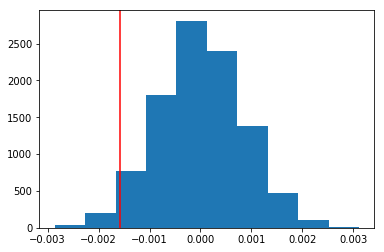

In [26]:
# plot the simulated null values
plt.hist(null_vals)

# plot the observed mean diff
plt.axvline(obs_diff, c='red');

### 4. Calculate the p-value

In [27]:
# we want to know if the new page leads to an increase in conversion rates so we calculate the proportion of
# null values above our observed value
# because our alternative hypothesis contains > we "shade" all null values on --> (this side) of the observed statistic
pval = (null_vals > obs_diff).mean()
pval

0.9703

### 5. Conclusion

A large p-value means we fail to reject the null hypothesis. Our threshold for type 1 errors is 0.05 and our computed p-value of 0.9703 is far above our threshold, therefore this is a large p-value and we fail to reject the null.

### 6. Built-In Alternative

In [28]:
# import statsmodels
import statsmodels.api as sm

In [29]:
# calculate the number of conversions for each page and total number of individuals for each page
convert_old = df.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

In [30]:
# use stats.proportions_ztest to compute the test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3116075339133115, 0.905173705140591)

### 7. Conclusion

The computed z_score tells us that our observed statistic is 1.3116 standard deviations from the null mean and our computed p-value of 0.9052 tells us that we fail to reject the null hypothesis.

<a id='regression'></a>
## Part 3 - A Regression Approach

### 1. Run a logistic regression with ab_test

In [31]:
# create intercept and dummy variables
df['intercept'] = 1
df[['ab_page', 'not_ab_page']] = pd.get_dummies(df['landing_page'])

# confirm ab_page column 1 for treatment and 0 for control
df.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,not_ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0


In [32]:
# drop unnecessary not_ab_page column
df.drop(columns='not_ab_page', inplace=True)

# confirm column was dropped
df.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1


In [33]:
# create and run the model, then store the results
log_mod = sm.Logit(df['converted'], df[['intercept', 'ab_page']])

results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
# display the model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:               8.085e-06
Time:                        00:49:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

### 2. Conclusion

The p-value associated with ab_page is 0.190. This p-value differs from the p-value from our hypothesis test because the regression's p-value provides different information.

The p-value associated with variables in our logistic regression tells us whether seeing the new page, as opposed to the old page, is a strong predictor of conversion.

With a p-value above our threshold of 0.05, our logistic regression shows us that ab_page alone is not a strong predictor of conversion.

Should we add other factors into our model?
It would be a good idea to add additional factors into our model since ab_page alone is not a strong predictor. However, it is possible that ab_page paired with additional factors is a stronger predictor of conversion. A potential disadvantage to adding factors into our model would be the appearance of multicollinearity if the terms are too closely related to each other.

### 3. Run a logistic regression with country of residence

In [35]:
# import countries.csv file
countries_df = pd.read_csv('countries.csv')

# join the country df with the existing df
df_new = countries_df.set_index('user_id').join(df.set_index('user_id'), how='inner')

In [36]:
# preview df_new to confirm join
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [37]:
# check for all unique country values in df_new
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [38]:
# create intercept and the necessary dummy variables
df_new['intercept'] = 1
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

# confirm dummy variables
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1


In [39]:
# create and run the model, then store the results
log_mod_2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])

results2 = log_mod_2.fit()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


In [40]:
# display model results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:               1.521e-05
Time:                        00:49:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

### 4. Conclusion

Due to the high p-values (greater than 0.05) associated with each of the country variables in our model, it does NOT appear that country has a significant impact on conversion.

### 5. Run a logistic regression with ab_page and country of residence

In [41]:
# create and run the model, then store the results
log_mod_3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])

results3 = log_mod_3.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [42]:
# display model results
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:               2.324e-05
Time:                        00:49:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

### 6. Conclusion

There has not been a significant change in the model. Due to the high p-values (greater than 0.05) associated with the ab_page variable and each of the country variables in our model, it does NOT appear that ab_page and country together has a significant impact on conversion.